<h2 style='text-align: center;'>AIPM -  MiniProject - CH22M503</h2>

<h3 style='text-align: center;'>Author - Aloy Banerjee</h3>
<h3 style='text-align: center;'>Roll No. CH22M503</h3>

#### Importing Library

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Problem - 1: Kalman Filter
###### Implement the Kalman Filter to estimate the level of water in the 4 tanks present in the Quadruple tank experiment, as discussed in class. The experiment is explained in detail in the reference paper (Quadruple tank process) as in the link given below.
    - Link: https://drive.google.com/file/d/1XQ-O1Rov4L_b6n1J6dJQ7_3cUy-l-ik4/view?usp=sharing
###### Please use the same parameter values as described in the paper. For the initial conditions, use the minimum-phase characteristic values. The transfer functions given in the paper can be ignored for this assignment. Q and R values have to be tuned to attain convergence of the filter and get better accuracy with the estimates. Tolerance, defined as the L2 norm between prior and posterior state vectors, has to be less than or equal to 5 X 10-3. Measurements are sampled at a time interval of 0.1s. Measurement values obtained by solving the model equations have also been uploaded in the link given below. Use them as the true measurements.
    - Link: https://docs.google.com/spreadsheets/d/10lm7KOxo6k3etXTsW5t2KYcC7d0sGUlZ/edit?usp=sharing&ouid=108491382124139074371&rtpof=true&sd=true

#### Reference used 

#### Loading the data

In [97]:
# Load the data from an Excel file
tank_measurement_data = pd.read_excel('Link 2 Measurements.xlsx')
display(tank_measurement_data)

,h1,h2,h3,h4
0,12.400000,12.700000,1.800000,1.400000
1,12.404928,12.700618,1.792881,1.400301
2,12.409478,12.701239,1.786060,1.400592
3,12.413670,12.701863,1.779526,1.400873
4,12.417521,12.702490,1.773266,1.401145
...,...,...,...,...
9996,12.262968,12.783158,1.633941,1.409045
9997,12.262968,12.783158,1.633941,1.409045
9998,12.262968,12.783158,1.633941,1.409045
9999,12.262968,12.783158,1.633941,1.409045


#### Seperate each tank measurement 

In [98]:
# Separate the measurements for each tank
tank1_measurements = tank_measurement_data['h1'].values
tank2_measurements = tank_measurement_data['h2'].values
tank3_measurements = tank_measurement_data['h3'].values
tank4_measurements = tank_measurement_data['h4'].values

#### Display the result

In [99]:
print(tank1_measurements)
print(tank2_measurements)
print(tank3_measurements)
print(tank4_measurements)

[12.4        12.40492766 12.40947845 ... 12.26296752 12.26296752
 12.26296752]
[12.7        12.70061798 12.70123915 ... 12.7831584  12.7831584
 12.7831584 ]
[1.8        1.79288086 1.78606001 ... 1.63394113 1.63394113 1.63394113]
[1.4        1.40030108 1.40059211 ... 1.4090447  1.4090447  1.4090447 ]


#### Common variable declaration

In [100]:
# Create a time vector
time_steps = np.arange(len(tank1_measurements))
# Your measurements from the system
measurements = np.array([tank1_measurements, tank2_measurements, tank3_measurements, tank4_measurements]).T
num_tanks = measurements.shape[1]
num_measurements = len(measurements)

#### Kalman Filter

In [101]:
# Simulation of Kalman Filter Based on The Quadruple-Tank Process: A Multivariable Laboratory Process with an Adjustable Zero
# Karl Henrik Johansson. Parameter Initialization

h = tank_measurement_data.to_numpy()[0,:]
Ar = [28, 32, 28, 32]
ar = [0.071, 0.057, 0.071, 0.057]
g = 981.2

T = []
for i in range(len(h)):
    Time_const = (Ar[i] / ar[i]) * np.sqrt((2 * h[i]) / g)
    T.append(Time_const)

state_transition_matrix = np.array([[-1 / T[0], 0, Ar[2] / (Ar[0] * T[2]), 0],
              [0, -1 / T[1], 0, Ar[3] / (Ar[1] * T[3])],
              [0, 0, -1 / T[2], 0],
              [0, 0, 0, -1 / T[3]]])

print(f'state_transition_matrix :\n{state_transition_matrix}')

gamma_1, gamma_2= 0.7, 0.6
k1, k2 = 3.33, 3.35

control_input_matrix = np.array([[(gamma_1 * k1) / Ar[0], 0],
              [0, (gamma_2 * k2) / Ar[1]],
              [0, ((1 - gamma_2) * k2) / Ar[2]],
              [((1 - gamma_1) * k1) / Ar[3], 0]])

print(f'control_input_matrix :\n{control_input_matrix}')

control_input = np.array([[3], [3]])

# Initialize variables

initial_state = np.ones((num_tanks, 1))  # Initial state estimate
initial_error_covariance = 1e5 * np.eye(num_tanks)  # Initial error covariance

#measurement_noise_cov = 2 * np.eye(num_tanks)  # Measurement noise covariance
measurement_noise_cov = 2 * np.eye(2)  # Measurement noise covariance

kc=0.5
#observation_matrix=[[kc,0,0,0],[0,kc,0,0],[0,0,kc,0],[0,0,0,kc]]
observation_matrix=[[kc,0,0,0],[0,kc,0,0]]
observation_matrix=np.array(observation_matrix)

print(f'observation_matrix :\n{observation_matrix}')

# Initialize lists to store values for plotting
X_post_list,X_prior_list,P_post_list,P_pri_list,Kalman_gain_list = [],[],[],[],[]

l2_norm_converged = False  # Flag to track L2 norm convergence

state_transition_matrix :
[[-0.01594973  0.          0.04186276  0.        ]
 [ 0.         -0.011071    0.          0.03334453]
 [ 0.          0.         -0.04186276  0.        ]
 [ 0.          0.          0.         -0.03334453]]
control_input_matrix :
[[0.08325    0.        ]
 [0.         0.0628125 ]
 [0.         0.04785714]
 [0.03121875 0.        ]]
observation_matrix :
[[0.5 0.  0.  0. ]
 [0.  0.5 0.  0. ]]


#### Particle Filter

In [102]:
# particles for our particle filter
number_of_particles = 1000 
# replace this with your method for initializing particles
initial_particles = np.random.rand(number_of_particles, num_tanks)  
 # start with equal confidence in all particles : Initialize weights
initial_weights = np.ones(number_of_particles) / number_of_particles

#### Common function

In [103]:
def kalman_filter_simulation(z, u, A, B, H, Q, R, P, x): 
    """
    Simulates a Kalman filter given the measurements and system parameters.

    Args:
        z (numpy.ndarray): Array of shape (num_measurements, num_features) containing the measurements.
        u (numpy.ndarray): Array of shape (num_measurements, num_inputs) containing the control inputs.
        A (numpy.ndarray): System dynamics matrix of shape (num_features, num_features).
        B (numpy.ndarray): Control matrix of shape (num_features, num_inputs).
        H (numpy.ndarray): Observation Measurement matrix of shape (num_measurements, num_features).
        Q (numpy.ndarray): Process noise covariance matrix of shape (num_features, num_features).
        R (numpy.ndarray): Measurement noise covariance matrix of shape (num_measurements, num_measurements).
        P (numpy.ndarray): Initial state covariance matrix of shape (num_features, num_features).
        x (numpy.ndarray): Initial state vector of shape (num_features,).

    Returns:
        Tuple: A tuple containing lists of estimated states, post-measurement state covariances,
        prior-measurement state covariances, and Kalman gains.

    """
    # Number of measurements
    num_measurements = len(z)
    l2_norm_converged = False  # Flag to track L2 norm convergence
    X_post_list,X_prior_list,P_post_list,P_pri_list,Kalman_gain_list = [],[],[],[],[]
    for k in range(num_measurements):
        # Prediction step
        X_pri = np.dot(A, x) + np.dot(B, u[:].reshape(-1, 1)) # Prior state estimate
        P_pri = np.dot(np.dot(A, P), A.T) + Q # Prior state covariance
        X_prior_list.append(X_pri.flatten()) # Store prior state estimate  
        
        # Update step
        K = np.dot(np.dot(P_pri, H.T), np.linalg.inv(np.dot(np.dot(H, P_pri), H.T) + R)) # Kalman gain
        Z_est = np.dot(H, X_pri) # Estimated measurement
        #E = z[k,:4] - Z_est.flatten() # Measurement error
        E = z[k,:2] - Z_est.flatten() # Measurement error
        
        initial_state = X_pri + np.dot(K, E.reshape(-1, 1)) # Updated state estimate
        P = P_pri - np.dot(np.dot(K, H), P_pri) # Updated state covariance
        x = initial_state # Updated the initial states
        
        # Append values to the lists
        X_post_list.append(initial_state.flatten()) # Store post-measurement state estimate
        P_post_list.append(np.trace(P)) # Store post-measurement state covariance
        P_pri_list.append(np.trace(P_pri)) # Store prior-measurement state covariance
        Kalman_gain_list.append(np.trace(K)) # Store Kalman gain
        
        # Calculate the L2 norm        
        l2_norm = np.linalg.norm(X_pri - initial_state)
        threshold = 5e-3
        l2_norm_converged = False
        
        if np.allclose(l2_norm, threshold) and not l2_norm_converged:
            print(f"L2 norm converges to threshold value at {k} iteration")
            l2_norm_converged = True
            break

        # Stop condition: X_post - X_pri approx = 0
        # if np.allclose(initial_state, X_pri):
             # break
    
    estimated_states = initial_state.flatten()  # Final estimated states
    print("Posterior states:", estimated_states)      
    # Return simulation results
    return X_post_list, X_prior_list, P_post_list, P_pri_list, Kalman_gain_list


def particle_filter(N, z, particles, weights):
    """
    Implements the Particle filter for a system.
    
    Parameters:
    N (int): Number of particles.
    z (np.array): Vector of measurements for each time step.
    particles (np.array): Initial set of particles.
    weights (np.array): Initial weights of particles.

    Returns:
    x_estimates (np.array): Estimated state for each time step.
    """

    # Initialize matrix to hold state estimates for each time step
    n = particles.shape[1]  # number of states (i.e., dimension of a particle)
    Nt = len(z)  # number of time steps
    x_estimates = np.zeros((Nt, n))  # one row for each time step, one column for each state

    for i in range(Nt):
        # Predict step: move particles based on system dynamics
        particles = particle_filter_predict(particles)  # You need to define the predict function based on your process model

        # Update step: update weights based on measurement
        weights = particle_filter_update(particles, z[i], weights)  # You need to define the update function based on your measurement model

        # Resampling step: create a new set of particles
        particles = particle_filter_resample(particles, weights)  # Resample particles based on weights
        
        # Compute the weighted average of particles as the state estimate for this time step
        x_estimates[i] = np.average(particles, weights=weights, axis=0)

    # Return the state estimates for all time steps
    return x_estimates

def particle_filter_predict(particles):
    """
    Predicts the next state of the particles based on the system dynamics.
    
    Parameters:
    particles (np.array): The current state of the particles.

    Returns:
    particles (np.array): The predicted state of the particles.
    """
    # Add some process noise to each particle to represent uncertainty in the system dynamics
    # This step is based on the assumption that the particles follow a Gaussian distribution and 
    # the process noise is also Gaussian. The predict function simply adds some Gaussian noise 
    # to each particle which simulates the effect of process noise in the system.
    particles += np.random.normal(0, 0.1, particles.shape)  # Replace 0.1 with your own estimate of process noise

    # Returns the updated particles after adding the process noise
    return particles

def particle_filter_update(particles, z, weights):
    """
    Updates the weights of the particles based on the measurement.

    Parameters:
    particles (np.array): The current state of the particles.
    z (float): The current measurement.
    weights (np.array): The current weights of the particles.

    Returns:
    weights (np.array): The updated weights of the particles.
    """

    for i in range(len(particles)):
        # Calculate the difference between the predicted state (particle) and the actual measurement
        # This difference, or residual, is used to update the weight of the particle
        diff = z - particles[i]

        # Update the weight of this particle based on the difference
        # The weight is updated using the Gaussian probability density function, assuming the measurement noise is Gaussian
        # The larger the difference between the particle and the measurement, the smaller the weight will be
        # Replace this with your own noise model if necessary
        weights[i] = np.exp(-0.5 * np.dot(diff, diff))

    # Normalize the weights so they sum to 1
    # This is necessary as the weights represent the relative probability of each particle
    weights /= sum(weights)

    # Return the updated weights
    return weights

def particle_filter_resample(particles, weights):
    """
    Resamples the particles based on their weights.
    
    Parameters:
    particles (np.array): The current state of the particles.
    weights (np.array): The current weights of the particles.

    Returns:
    particles (np.array): The resampled particles.
    """

    # Generate a set of indices for resampling. Indices are chosen randomly, 
    # but particles with higher weights are more likely to be chosen. 
    # The size of the resampled array is the same as the original array of particles.
    indices = np.random.choice(np.arange(len(particles)), size=len(particles), p=weights)

    # Resample the particles based on the generated indices
    # The resampled array of particles contains duplicates of the same particle if that particle's weight is high
    particles = particles[indices]

    # Reset all weights to be equal
    # This is done because after resampling, all particles are equally likely (they've survived the 'survival of the fittest')
    weights = np.ones_like(weights) / len(particles)

    # Return the resampled particles
    return particles

def plot_tank_data(subplot_index, time_steps, tank_measurements, kalman_results, particle_results, tank_title, marker_kalman, marker_particle):
    """
    Plots the tank measurements, Kalman Filter results, and Particle Filter results on a 2x2 subplot.

    Args:
        subplot_index (int): The index of the subplot where this tank's data will be plotted.
        time_steps (array): An array representing the time steps.
        tank_measurements (array): An array of the original measurements for this tank.
        kalman_results (array): The results of the Kalman filter for this tank.
        particle_results (array): The results of the Particle filter for this tank.
        tank_title (str): The title for the subplot.
    """
    # Create a subplot on a 2x2 grid at the specified index
    plt.subplot(2, 2, subplot_index)    
    # Plot the Kalman Filter results against time steps, label it as 'Kalman Filter'
    plt.plot(time_steps, kalman_results, label='Kalman Filter', marker = marker_particle)    
    # Plot the Particle Filter results against time steps, label it as 'Particle Filter'
    plt.plot(time_steps, particle_results, label='Particle Filter', marker = marker_particle)    
    # Plot the original tank measurements against time steps, label it as 'Original'
    plt.plot(time_steps, tank_measurements, label='Original', marker = 'x')    
    # Set the title for this subplot to be the provided tank title
    plt.title(tank_title)    
    # Add a legend to the subplot
    plt.legend()  
    
def plot_filterwise_tank_data(subplot_num, time_steps, original_data, filter_results, tank_measurements, tank_name, marker):
    """
    Plots the tank data for a specific filter.

    Parameters:
        subplot_num (int): The subplot number for the current tank.
        time_steps (numpy.ndarray): Array of time steps.
        original_data (numpy.ndarray): Array of original tank data.
        filter_results (numpy.ndarray): Array of filter results for the current tank.
        tank_measurements (numpy.ndarray): Array of tank measurements for the current tank.
        tank_name (str): Name of the current tank.
        marker (str): Marking the tank wise plot

    Returns:
        None
    """
    # Create a subplot for the current tank
    plt.subplot(2, 2, subplot_num) 
    # Plot the original tank data
    plt.plot(time_steps, original_data, label='Original Data', color='#9A0EEA')  
    # Plot the filter results
    plt.plot(time_steps, filter_results, label='Filter Results', color='red')  
    # Plot the tank measurements
    plt.scatter(time_steps, tank_measurements, label='Measurements', color='#76FF7B', marker=marker, s = 30) 
    # Set the x-axis label
    plt.xlabel('Time Steps')  
    # Set the y-axis label
    plt.ylabel('Tank Level') 
    # Set the title for the subplot
    plt.title(tank_name)  
    # Show the legend
    plt.legend()     

#### Looping through different combination to see the best convergence

In [138]:
for hyperparameter in range(1,11,1):
    process_noise_cov = hyperparameter * np.eye(num_tanks)  # Process noise covariance 
    #process_noise_cov[2,0] = process_noise_cov[3, 1] = process_noise_cov[0,2] = process_noise_cov[1,3] = process_noise_cov[2,2] = process_noise_cov[3,3] = 1
    print(f'hyperparameter value {hyperparameter}')
    X_post_list_loop, X_prior_list_loop, _, _, _ = kalman_filter_simulation(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov, measurement_noise_cov, initial_error_covariance, initial_state)

hyperparameter value 1
Posterior states: [2.91549207 2.98449633 0.13324816 0.08759252]
hyperparameter value 2
Posterior states: [5.05249697 5.22493903 0.12959493 0.08515466]
hyperparameter value 3
Posterior states: [6.80483577 7.06091302 0.1265995  0.08315699]
hyperparameter value 4
Posterior states: [8.26780509 8.59288435 0.12409885 0.08149015]
hyperparameter value 5
Posterior states: [9.50762158 9.8905888  0.12197974 0.08007824]
hyperparameter value 6
Posterior states: [10.57172888 11.00394729  0.12016102  0.07886693]
hyperparameter value 7
Posterior states: [11.49501064 11.96963713  0.11858304  0.0778163 ]
hyperparameter value 8
Posterior states: [12.30368913 12.81521076  0.11720097  0.07689637]
hyperparameter value 9
Posterior states: [13.01785649 13.56176738  0.11598046  0.07608417]
hyperparameter value 10
Posterior states: [13.6531672  14.22573778  0.11489474  0.07536183]


##### Hyper parameter value of 8 is among all other are giving close to real value hence selecting that value for process noise covariance

#### Calling Kalman filter function for estimation

In [105]:
kalman_filter_results = []

In [139]:
process_noise_cov = 8 * np.eye(num_tanks)  # Process noise covariance
print(f'process_noise_cov : {process_noise_cov}')
X_post_list_loop, X_prior_list_loop, _, _, _ = kalman_filter_simulation(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov, measurement_noise_cov, initial_error_covariance, initial_state)

Q = 8 * np.eye(num_tanks)
Q[2,0] = Q[3, 1] = Q[0,2] = Q[1,3] = Q[2,2] = Q[3,3] = 1
process_noise_cov = Q
print(f'process_noise_cov : {process_noise_cov}')
X_post_list_loop, X_prior_list_loop, _, _, _ = kalman_filter_simulation(measurements, control_input, state_transition_matrix, control_input_matrix, observation_matrix, process_noise_cov, measurement_noise_cov, initial_error_covariance, initial_state)

process_noise_cov : [[8. 0. 0. 0.]
 [0. 8. 0. 0.]
 [0. 0. 8. 0.]
 [0. 0. 0. 8.]]
Posterior states: [12.30368913 12.81521076  0.11720097  0.07689637]
process_noise_cov : [[8. 0. 1. 0.]
 [0. 8. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]]
Posterior states: [12.32456416 12.83442585  1.5997698   1.62944216]


In [126]:
X_post_list_loop = np.array(X_post_list_loop)
X_prior_list_loop = np.array(X_prior_list_loop)

#### Plotting the Kalman filter estimates over each time steps 

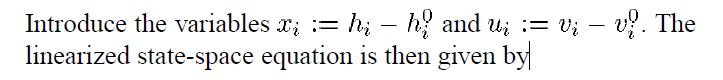

In [127]:
print(f'Tank 1 : Prior Estimate : {np.mean(X_prior_list_loop[:, 0] + h[0])}')
print(f'Tank 2 : Prior Estimate : {np.mean(X_prior_list_loop[:, 1] + h[1])}')
print(f'Tank 3 : Prior Estimate : {np.mean(X_prior_list_loop[:, 2] + h[2])}')
print(f'Tank 4 : Prior Estimate : {np.mean(X_prior_list_loop[:, 3] + h[3])}')

Tank 1 : Prior Estimate : 12.520039370257772
Tank 2 : Prior Estimate : 12.800616180485653
Tank 3 : Prior Estimate : 1.8766791294058354
Tank 4 : Prior Estimate : 1.4393979908132495


In [128]:
X_prior_list_loop[:, 3]

array([0.06031172, 0.75534392, 0.01575265, ..., 0.03932326, 0.03932326,
       0.03932326])

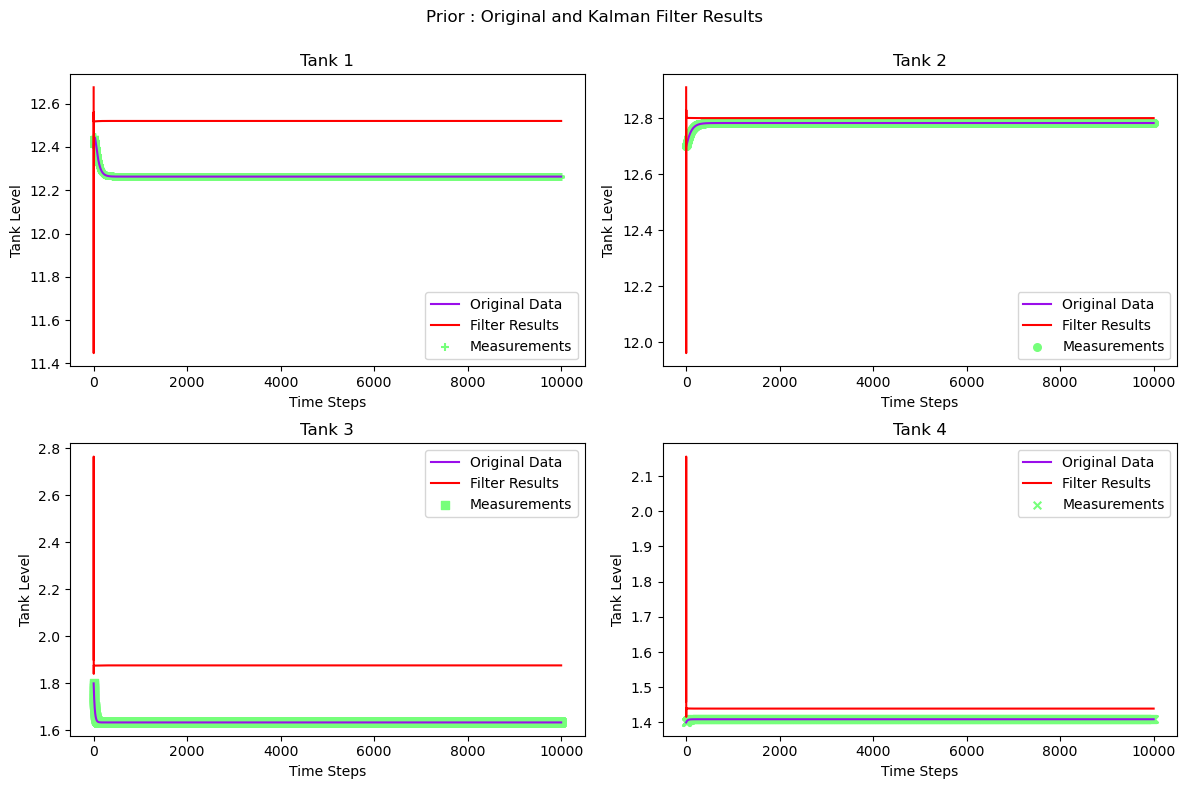

In [129]:
# Initialize the plot for original data and Kalman filter results
plt.figure(figsize=(12, 8))
plt.suptitle('Prior : Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_prior_list_loop[:, 0] + h[0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_prior_list_loop[:, 1] + h[1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_prior_list_loop[:, 2] + h[2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_prior_list_loop[:, 3] + h[3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [130]:
print(f'Tank 1 : Posterior Estimate : {np.mean(X_post_list_loop[:, 0])}')
print(f'Tank 2 : Posterior Estimate : {np.mean(X_post_list_loop[:, 1])}')
print(f'Tank 3 : Posterior Estimate : {np.mean(X_post_list_loop[:, 2])}')
print(f'Tank 4 : Posterior Estimate : {np.mean(X_post_list_loop[:, 3])}')

Tank 1 : Posterior Estimate : 12.327545966196496
Tank 2 : Posterior Estimate : 12.834676140667758
Tank 3 : Posterior Estimate : 1.597955150742644
Tank 4 : Posterior Estimate : 1.6272640199417834


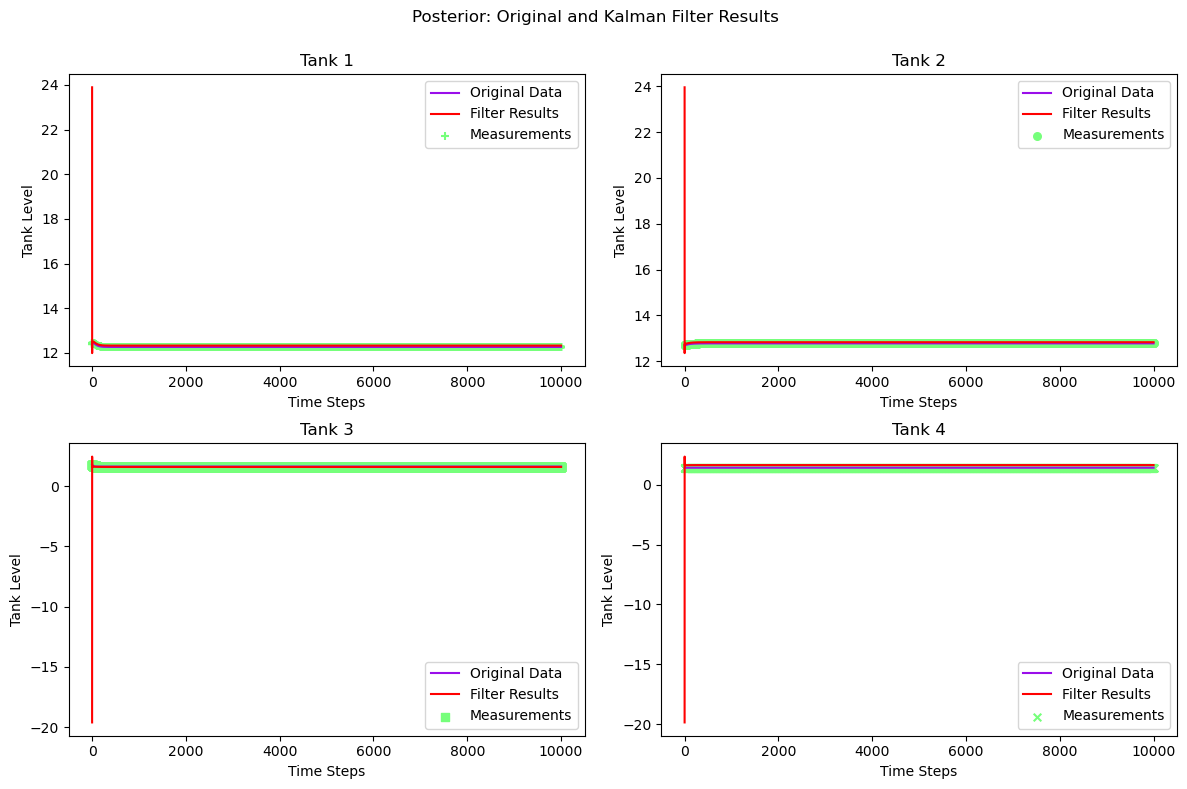

In [131]:
# Initialize the plot for original data and Kalman filter results
plt.figure(figsize=(12, 8))
plt.suptitle('Posterior: Original and Kalman Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, X_post_list_loop[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, X_post_list_loop[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, X_post_list_loop[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, X_post_list_loop[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Problem - 2: Particle filter
###### Implement the Particle Filter to estimate the level of water in the 4 tanks present in the Quadruple tank experiment, as discussed in class. Follow the same procedures as mentioned in Problem 1.

##### Implementation of a Particle Filter, a type of sequential Monte Carlo method used for estimating the state of a system given a sequence of measurements.

#### Calling Particle filter function for estimation

In [132]:
# Call the Particle filter function
particle_filter_results = particle_filter(number_of_particles, measurements, initial_particles, initial_weights)

#### Plotting the Particle filter estimates over each time steps 

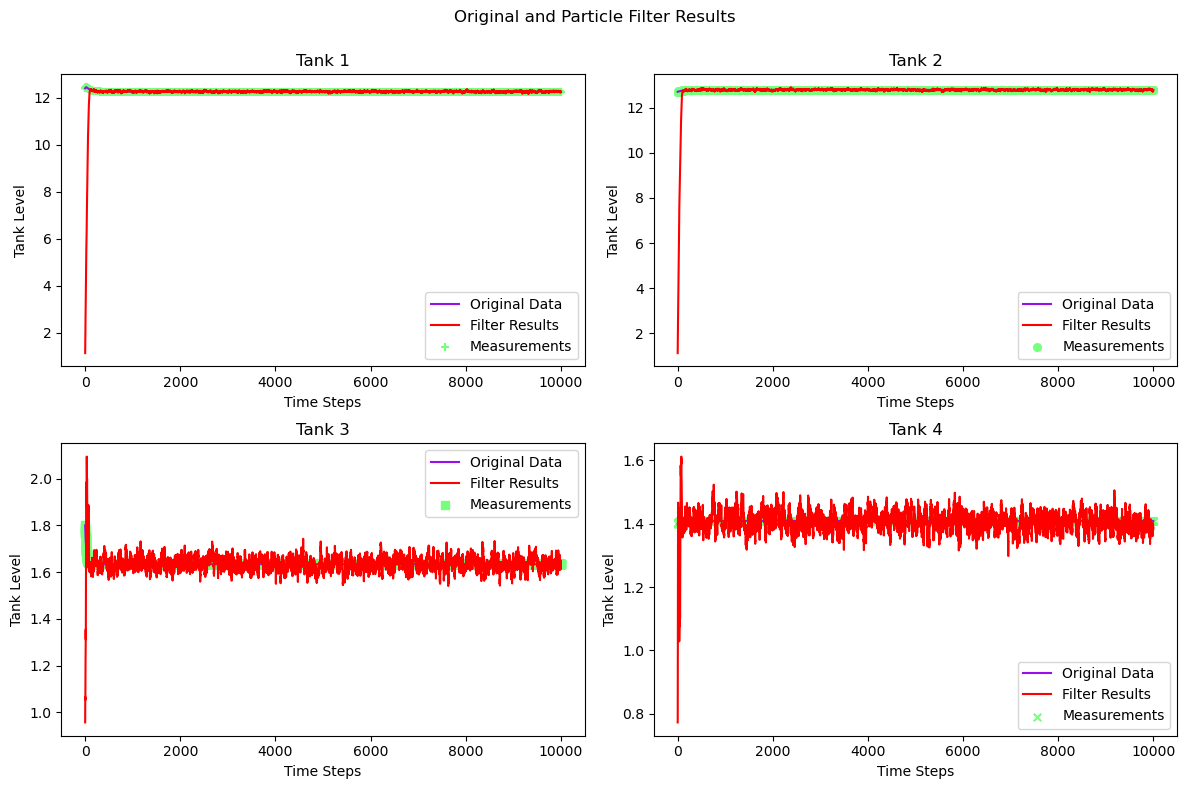

In [133]:
# Initialize the plot for original data and Particle filter results
plt.figure(figsize=(12, 8))
plt.suptitle('Original and Particle Filter Results')

plot_filterwise_tank_data(1, time_steps, tank1_measurements, particle_filter_results[:, 0], tank1_measurements, 'Tank 1', '+')
plot_filterwise_tank_data(2, time_steps, tank2_measurements, particle_filter_results[:, 1], tank2_measurements, 'Tank 2', 'o')
plot_filterwise_tank_data(3, time_steps, tank3_measurements, particle_filter_results[:, 2], tank3_measurements, 'Tank 3', 's')
plot_filterwise_tank_data(4, time_steps, tank4_measurements, particle_filter_results[:, 3], tank4_measurements, 'Tank 4', 'x')

# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

### Problem - 3: Comparison
###### Compare the results obtained from Part 1 and 2 with the actual measured values and document your inferences.

#### Plot the result for both Kalman Filter and Particle Filter

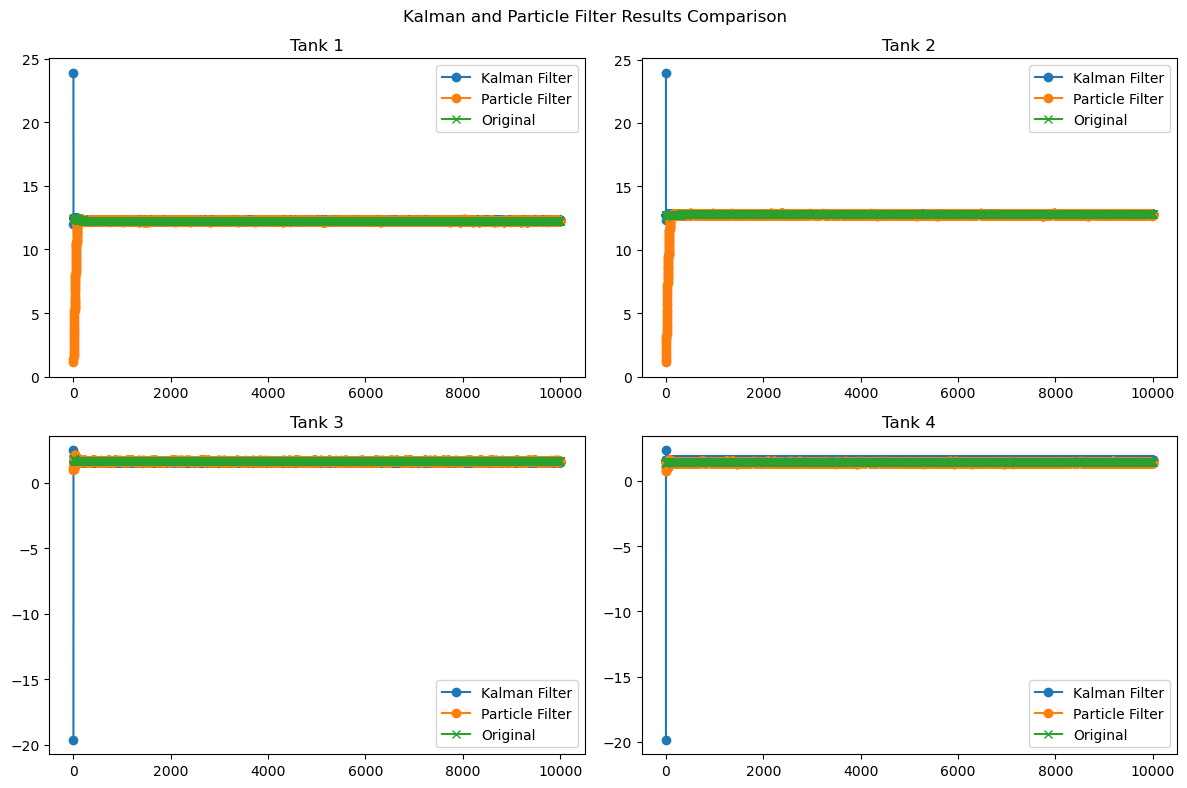

In [134]:
# Initialize the plot
plt.figure(figsize=(12, 8))
plt.suptitle('Kalman and Particle Filter Results Comparison')
# Plotting the Kalman Filter and Particle Filter Measurement 
plot_tank_data(1, time_steps, tank1_measurements, X_post_list_loop[:, 0], particle_filter_results[:, 0], 'Tank 1', '+', 'o')
plot_tank_data(2, time_steps, tank2_measurements, X_post_list_loop[:, 1], particle_filter_results[:, 1], 'Tank 2', '+', 'o')
plot_tank_data(3, time_steps, tank3_measurements, X_post_list_loop[:, 2], particle_filter_results[:, 2], 'Tank 3', '+', 'o')
plot_tank_data(4, time_steps, tank4_measurements, X_post_list_loop[:, 3], particle_filter_results[:, 3], 'Tank 4', '+', 'o')


# Adjust the subplot layout, so the plots do not overlap
plt.tight_layout()
plt.show()


#### Tabularize the data for better visibility and comparison between the convergence between Kalman and Particle Filter estimation

In [135]:
# Create a dataframe with the results
results_dataframe = pd.DataFrame({
    'Time_Step': time_steps,
    'Original_Tank1_Reading': tank1_measurements,
    'KalmanFilter_Tank1_Estimate': X_post_list_loop[:, 0],
    'ParticleFilter_Tank1_Estimate': particle_filter_results[:, 0],
    'Original_Tank2_Reading': tank2_measurements,
    'KalmanFilter_Tank2_Estimate': X_post_list_loop[:, 1],
    'ParticleFilter_Tank2_Estimate': particle_filter_results[:, 1],
    'Original_Tank3_Reading': tank3_measurements,
    'KalmanFilter_Tank3_Estimate': X_post_list_loop[:, 2],
    'ParticleFilter_Tank3_Estimate': particle_filter_results[:, 2],
    'Original_Tank4_Reading': tank4_measurements,
    'KalmanFilter_Tank4_Estimate': X_post_list_loop[:, 3],
    'ParticleFilter_Tank4_Estimate': particle_filter_results[:, 3]
})

# Display the dataframe
display(results_dataframe)


,Time_Step,Original_Tank1_Reading,KalmanFilter_Tank1_Estimate,ParticleFilter_Tank1_Estimate,Original_Tank2_Reading,KalmanFilter_Tank2_Estimate,ParticleFilter_Tank2_Estimate,Original_Tank3_Reading,KalmanFilter_Tank3_Estimate,ParticleFilter_Tank3_Estimate,Original_Tank4_Reading,KalmanFilter_Tank4_Estimate,ParticleFilter_Tank4_Estimate
0,0,12.400000,23.894577,1.126758,12.700000,23.954857,1.122735,1.800000,-19.619429,0.956607,1.400000,-19.843963,0.772333
1,1,12.404928,11.987778,1.402174,12.700618,12.358714,1.279706,1.792881,2.459294,1.046865,1.400301,2.336323,0.785930
2,2,12.409478,12.491902,1.645440,12.701239,12.766955,1.470929,1.786060,1.579253,1.066136,1.400592,1.593773,0.908304
3,3,12.413670,12.473522,1.796375,12.701863,12.752904,1.711609,1.779526,1.619659,1.053165,1.400873,1.620507,1.043097
4,4,12.417521,12.478365,1.936018,12.702490,12.754053,1.919695,1.773266,1.618325,1.062625,1.401145,1.619628,1.071836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,9996,12.262968,12.324564,12.229715,12.783158,12.834426,12.713891,1.633941,1.599770,1.635272,1.409045,1.629442,1.399836
9997,9997,12.262968,12.324564,12.230660,12.783158,12.834426,12.719475,1.633941,1.599770,1.633795,1.409045,1.629442,1.394030
9998,9998,12.262968,12.324564,12.243218,12.783158,12.834426,12.728203,1.633941,1.599770,1.640503,1.409045,1.629442,1.381054
9999,9999,12.262968,12.324564,12.245872,12.783158,12.834426,12.740302,1.633941,1.599770,1.650185,1.409045,1.629442,1.393661


#### Saving the compared data between Kalman and Particle Filter estimates

In [136]:
results_dataframe.to_csv('Comparison_New.csv', sep=',', index=False, encoding='utf-8')

### **Conclusion :**

###### 1. Looking at the observation value and estimated value it has been observed that for all 4 tank Particle filter is converging to the actual(reading) value much closure compared to Kalman filter. 



###### The 4 tank problem involves estimating the water levels in four interconnected tanks based on noisy measurements. Both the Kalman filter and particle filter are commonly used estimation techniques, but they have different underlying principles and assumptions.

- **Nonlinearity and Non-Gaussianity**: The 4 tank problem is nonlinear, meaning that the system dynamics and measurement equations do not follow a linear relationship. Additionally, the noise in the problem may not follow a Gaussian distribution. The Kalman filter assumes linearity and Gaussian noise, which may lead to suboptimal performance in nonlinear and non-Gaussian scenarios. On the other hand, particle filters can handle both nonlinear system dynamics and non-Gaussian noise, making them more suitable for the 4 tank problem.

- **Multimodal Distributions**: The water levels in the tanks may exhibit multimodal distributions due to the complex interaction between the tanks. The particle filter is capable of representing multimodal distributions by using a set of particles, where each particle represents a possible state hypothesis. This allows the particle filter to capture multiple modes and provide a more accurate estimation compared to the Kalman filter, which assumes a unimodal Gaussian distribution.

- **Resampling**: Particle filters use a resampling step to adaptively allocate more particles to regions of higher probability. This helps to focus the estimation on promising areas of the state space and mitigate the effects of particle degeneracy. In the 4 tank problem, where the system dynamics and measurements may be highly nonlinear and the noise can be non-Gaussian, resampling helps the particle filter to maintain a diverse set of particles and provide better estimation accuracy.

- **Computational Complexity**: Particle filters can be computationally more intensive compared to the Kalman filter, especially when dealing with a large number of particles. However, advancements in particle filter algorithms, such as sequential Monte Carlo methods, have made them more efficient and practical for real-time applications.

In summary, the particle filter outperforms the Kalman filter in the 4 tank problem because it can handle nonlinear system dynamics, non-Gaussian noise, multimodal distributions, and adaptively allocate particles through resampling. These capabilities allow the particle filter to provide better estimation accuracy and capture the complex behavior of the interconnected tanks.

<h3 style='text-align: center;'>=======================End of Mini Project=======================</h3>